# Imports

In [139]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import math

import datetime

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import joblib


# Read Merged Data



In [140]:
url_merge_data = "https://raw.githubusercontent.com/fsmariam/HydroLogic/refs/heads/main/data/processed/Merged_Training_Set.csv"
df_train = pd.read_csv(url_merge_data)

In [141]:
df_train.head()


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Convert Categorical Variables to Appropriate Formats

Categorical variables fall into two types:
- Low Cardinality: (Few unique values, and Good candidates for One-Hot Encoding)
- High Cardinality: (Many unique values, and Good to Use for Label Encoding, Frequency Encoding, or Target Encoding)

In [142]:
# Summary of categorical columns
cat_summary = df_train.select_dtypes(include='object').nunique().sort_values(ascending=False)
print(cat_summary)


wpt_name                 37399
subvillage               19287
scheme_name               2695
installer                 2145
ward                      2092
funder                    1896
date_recorded              356
lga                        125
region                      21
extraction_type             18
extraction_type_group       13
management                  12
scheme_management           11
source                      10
basin                        9
water_quality                8
extraction_type_class        7
payment                      7
payment_type                 7
source_type                  7
waterpoint_type              7
quality_group                6
waterpoint_type_group        6
management_group             5
quantity                     5
quantity_group               5
source_class                 3
status_group                 3
public_meeting               2
permit                       2
recorded_by                  1
dtype: int64


## Define Encoding Strategy
- High Cardinality: use the frequency or lable strategy, keeps dimensionality low
(wpt_name, subvillage, scheme_name, ward, date_recorded, lga, region, extraction_type, extraction_type_group, management, installer, funder, scheme_management)

- Low Cardinality: one-Hot Encoding strategy, preffered for non-ordinal categories
(source, basin, water_quality, source_type, waterpoint_type, extraction_type_class, payment_type, payment, quality_group, waterpoint_type_group, quantity, quantity_group, management_group, source_class, status_group)

- Boolean-like string, Map to 0/1. 
(permit or public_meeting)

## Implement Encoding

In [143]:
# Create a copy for encoding
df_encoded = df_train.copy()

## One-Hot Encode Low Cardinality Columns

In [144]:
# Identify all categorical columns
cat_columns = df_encoded.select_dtypes(include='object').columns.tolist()

# Count unique values to understand cardinality
cat_uniques = df_encoded[cat_columns].nunique()

# Select low cardinality columns (2–10 unique values)
low_card_cols = cat_uniques[(cat_uniques <= 10) & (cat_uniques > 1)].index.tolist()

# Apply one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=low_card_cols, drop_first=True)

# Preview result
print(f"Total new shape: {df_encoded.shape}")
print("First few column names:", df_encoded.columns[:10].tolist())

Total new shape: (59400, 106)
First few column names: ['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private']


## Frequency Encode High Cardinality Columns

In [145]:
# Re-identify remaining categorical columns
remaining_cat_cols = df_encoded.select_dtypes(include='object').columns.tolist()

# Recalculate high cardinality columns (more than 10 unique values)
cat_uniques = df_encoded[remaining_cat_cols].nunique()
high_card_cols = cat_uniques[cat_uniques > 10].index.tolist()

# Apply frequency encoding
for col in high_card_cols:
    freq_map = df_encoded[col].value_counts().to_dict()
    df_encoded[col + '_freq'] = df_encoded[col].map(freq_map)

In [146]:
# Check result
print("Final encoded shape:", df_encoded.shape)
df_encoded.head()

Final encoded shape: (59400, 119)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,wpt_name_freq,subvillage_freq,region_freq,lga_freq,ward_freq,scheme_management_freq,scheme_name_freq,extraction_type_freq,extraction_type_group_freq,management_freq
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,3563.0,6.0,5294,564,36,36793.0,139.0,26780,26780,40507
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,830.0,5.0,1969,716,71,766.0,NaN,26780,26780,6515
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,3.0,502.0,1583,308,10,36793.0,9.0,26780,26780,40507
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,1.0,17.0,1730,158,32,36793.0,NaN,4764,6179,40507
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,1748.0,2.0,3316,771,13,NaN,NaN,26780,26780,844


# Check for and Handle Outliers in Numerical Features

## Identify Numerical Columns

In [147]:
# Get numeric columns, but exclude ID or code-like columns
numeric_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
excluded = ['id', 'region_code', 'district_code']  # Don't plot these
numeric_cols = [col for col in numeric_cols if col not in excluded]
numeric_cols

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'num_private',
 'population',
 'construction_year',
 'date_recorded_freq',
 'funder_freq',
 'installer_freq',
 'wpt_name_freq',
 'subvillage_freq',
 'region_freq',
 'lga_freq',
 'ward_freq',
 'scheme_management_freq',
 'scheme_name_freq',
 'extraction_type_freq',
 'extraction_type_group_freq',
 'management_freq']

# Visualize Distributions

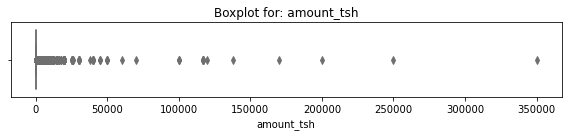

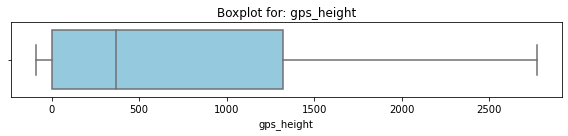

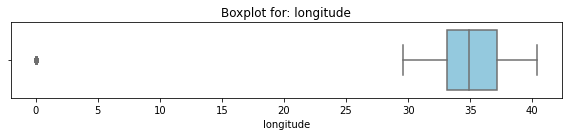

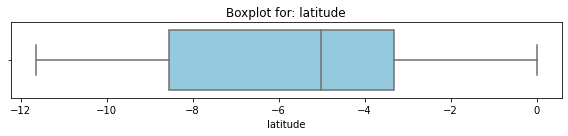

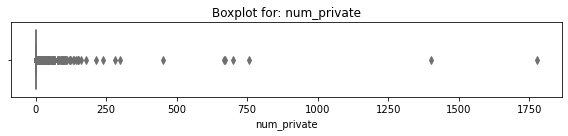

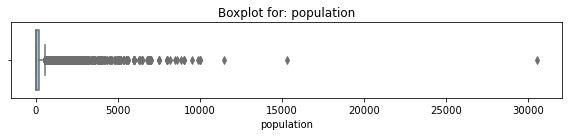

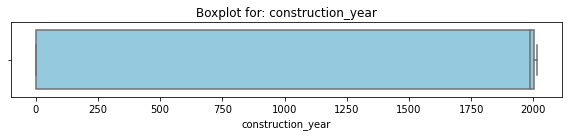

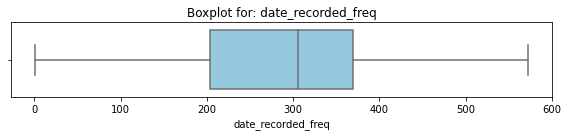

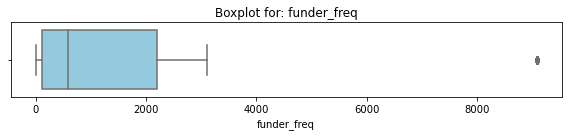

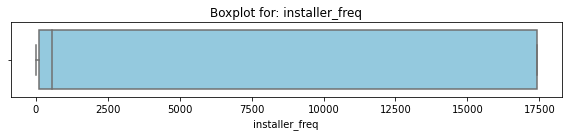

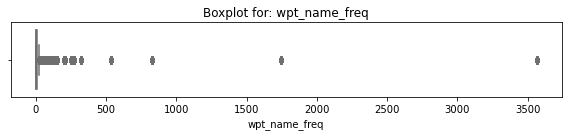

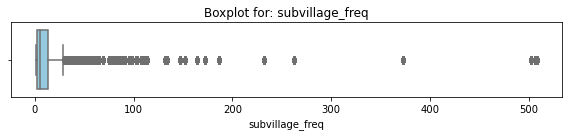

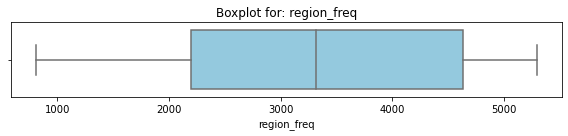

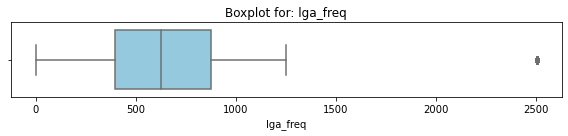

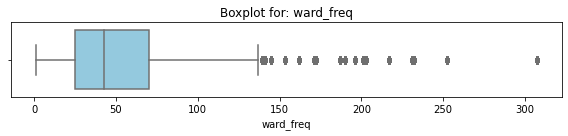

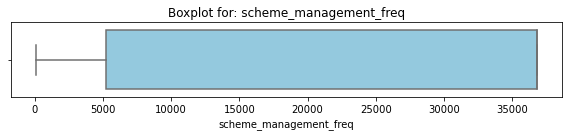

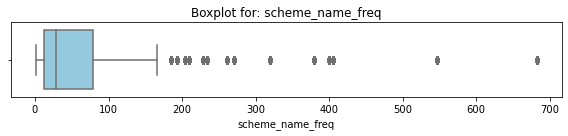

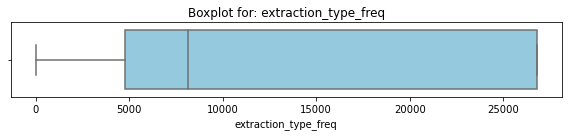

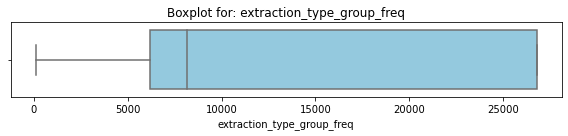

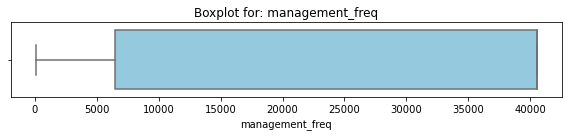

In [148]:

# Loop and plot boxplot for each column
for col in numeric_cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df_encoded[col], color='skyblue')
    plt.title(f'Boxplot for: {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

## Detect Outliers (Statistical Methods)

In [149]:
# Cap Outliers Using IQR and Flag Them
def cap_outliers_iqr(df, column):
    # Backup original values
    df[f'{column}_before_clip'] = df[column]

# Calculates lower and upper bounds for acceptable values using IQR
    # Calculate IQR bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Flag which values were outliers
    df[f'{column}_was_outlier'] = (df[column] < lower) | (df[column] > upper)

    # Apply clipping
    df[column] = df[column].clip(lower, upper)

    print(f"{column}: Capped outliers outside [{lower:.2f}, {upper:.2f}]")
    return df

# Apply to selected columns
columns_to_cap = ['amount_tsh', 'population', 'gps_height', 'num_private','longitude', 'latitude']

for col in columns_to_cap:
    df_encoded = cap_outliers_iqr(df_encoded, col)

amount_tsh: Capped outliers outside [-30.00, 50.00]
population: Capped outliers outside [-322.50, 537.50]
gps_height: Capped outliers outside [-1978.88, 3298.12]
num_private: Capped outliers outside [0.00, 0.00]
longitude: Capped outliers outside [26.96, 43.31]
latitude: Capped outliers outside [-16.36, 4.50]


In [150]:
# Apply Domain-Based Clipping to longitude
# Reasonable Tanzania bounds: longitude between 29 and 41 and latitude -12 to -1
# Clipping helps make location-based features more reliable
print("longitude: Clipping values to range [29, 41] based on valid GPS range for Tanzania")
df_encoded['longitude'] = df_encoded['longitude'].clip(lower=29, upper=41)

print("latitude: Clipping values to range [-12, -1] based on valid GPS range for Tanzania")
df_encoded['latitude'] = df_encoded['latitude'].clip(lower=-12, upper=-1)

longitude: Clipping values to range [29, 41] based on valid GPS range for Tanzania
latitude: Clipping values to range [-12, -1] based on valid GPS range for Tanzania


## Visualize Before vs After

In [151]:
def show_before_after(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 2))
    sns.boxplot(x=df_encoded[f"{col}_before_clip"], ax=axes[0], color='skyblue')
    axes[0].set_title(f'Before Clipping: {col}')
    sns.boxplot(x=df_encoded[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'After Clipping: {col}')
    for ax in axes:
        ax.grid(True)
        ax.set_xlabel('')
    plt.tight_layout()
    plt.show()


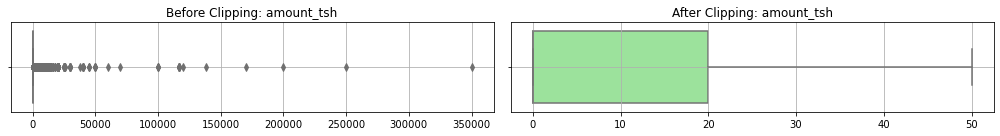

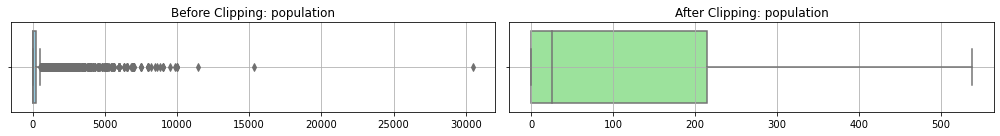

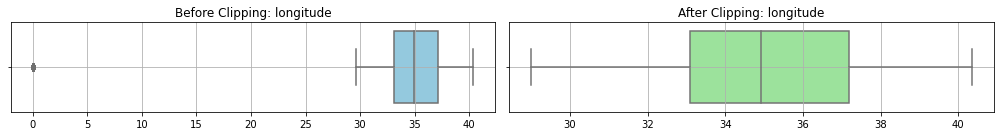

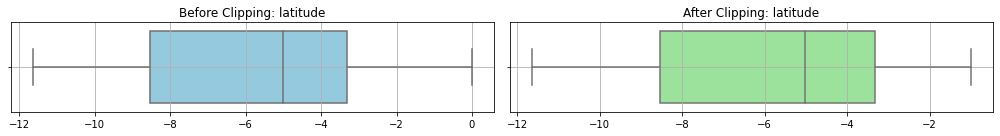

In [152]:
show_before_after('amount_tsh')
show_before_after('population')
show_before_after('longitude')
show_before_after('latitude')

# Normalize / Standardize Numerical Features

In [153]:
# column to scale:
scale_cols = ['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population']

In [154]:
# Apply Scaling


# Initialize and apply the scaler
scaler = StandardScaler()
df_encoded[scale_cols] = scaler.fit_transform(df_encoded[scale_cols])

# Inspect the result
print(df_encoded[scale_cols].describe().T)
# Save the scaler for future use (test set)

joblib.dump(scaler, 'scaler.pkl')

              count          mean       std       min       25%       50%  \
amount_tsh  59400.0  7.815335e-16  1.000008 -0.607771 -0.607771 -0.607771   
gps_height  59400.0  1.731275e-16  1.000008 -1.094050 -0.964200 -0.431817   
longitude   59400.0 -2.511425e-15  1.000008 -2.147239 -0.674102 -0.019207   
latitude    59400.0  4.181466e-16  1.000008 -2.044980 -0.969793  0.247263   
population  59400.0 -3.366987e-16  1.000008 -0.731708 -0.731708 -0.589268   

                 75%       max  
amount_tsh  0.345703  1.775913  
gps_height  0.939176  3.032277  
longitude   0.798205  1.938729  
latitude    0.833632  1.638134  
population  0.493270  2.330735  


['scaler.pkl']

In [155]:
df_encoded[scale_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
amount_tsh,59400.0,7.815335e-16,1.000008,-0.607771,-0.607771,-0.607771,0.345703,1.775913
gps_height,59400.0,1.731275e-16,1.000008,-1.094050,-0.964200,-0.431817,0.939176,3.032277
longitude,59400.0,-2.511425e-15,1.000008,-2.147239,-0.674102,-0.019207,0.798205,1.938729
latitude,59400.0,4.181466e-16,1.000008,-2.044980,-0.969793,0.247263,0.833632,1.638134
population,59400.0,-3.366987e-16,1.000008,-0.731708,-0.731708,-0.589268,0.493270,2.330735


In [156]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Build a Data Cleaning Pipeline

In [157]:
# Custom IQR Clipping Transformer
class IQRClipper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.bounds = {}

    def fit(self, X, y=None):
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            self.bounds[col] = (lower, upper)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            lower, upper = self.bounds[col]
            X[col] = X[col].clip(lower, upper)
        return X

In [158]:
# Define Preprocessing Pipeline
# Columns to apply IQR clipping and scaling
clip_scale_cols = ['amount_tsh', 'population']

# Build the pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('clip_outliers', IQRClipper(columns=clip_scale_cols)),
    ('scale', StandardScaler())
])

In [ ]:
# Apply pipeline only to selected columns
df_encoded[clip_scale_cols] = preprocessing_pipeline.fit_transform(df_encoded[clip_scale_cols])

In [160]:
joblib.dump(preprocessing_pipeline, 'preprocessing_pipeline.pkl')

['preprocessing_pipeline.pkl']

In [161]:
df_encoded.shape

(59400, 131)